All libraries imported successfully
UNSEEN DATA OVERVIEW
Shape: (30, 17)
Columns: ['Age', 'Gender', 'StudyHours', 'SleepHours', 'ReviewCenter', 'MockExamScore', 'GPA', 'Scholarship', 'InternshipGrade', 'IncomeLevel', 'EmploymentStatus', 'Confidence', 'TestAnxiety', 'EnglishProficiency', 'MotivationScore', 'SocialSupport', 'ExamResultPercent']

First 5 rows:
   Age  Gender  StudyHours  SleepHours  ReviewCenter  MockExamScore   GPA  Scholarship  InternshipGrade IncomeLevel EmploymentStatus  Confidence  TestAnxiety  EnglishProficiency  MotivationScore  SocialSupport  ExamResultPercent
0   23  Female           4           7             0            NaN  1.75            1             1.75        High          Skilled          10            4                   5                9              4               77.7
1   22  Female           5           7             0            NaN  1.25            0             1.75         Low       Unemployed           8            7                   4     

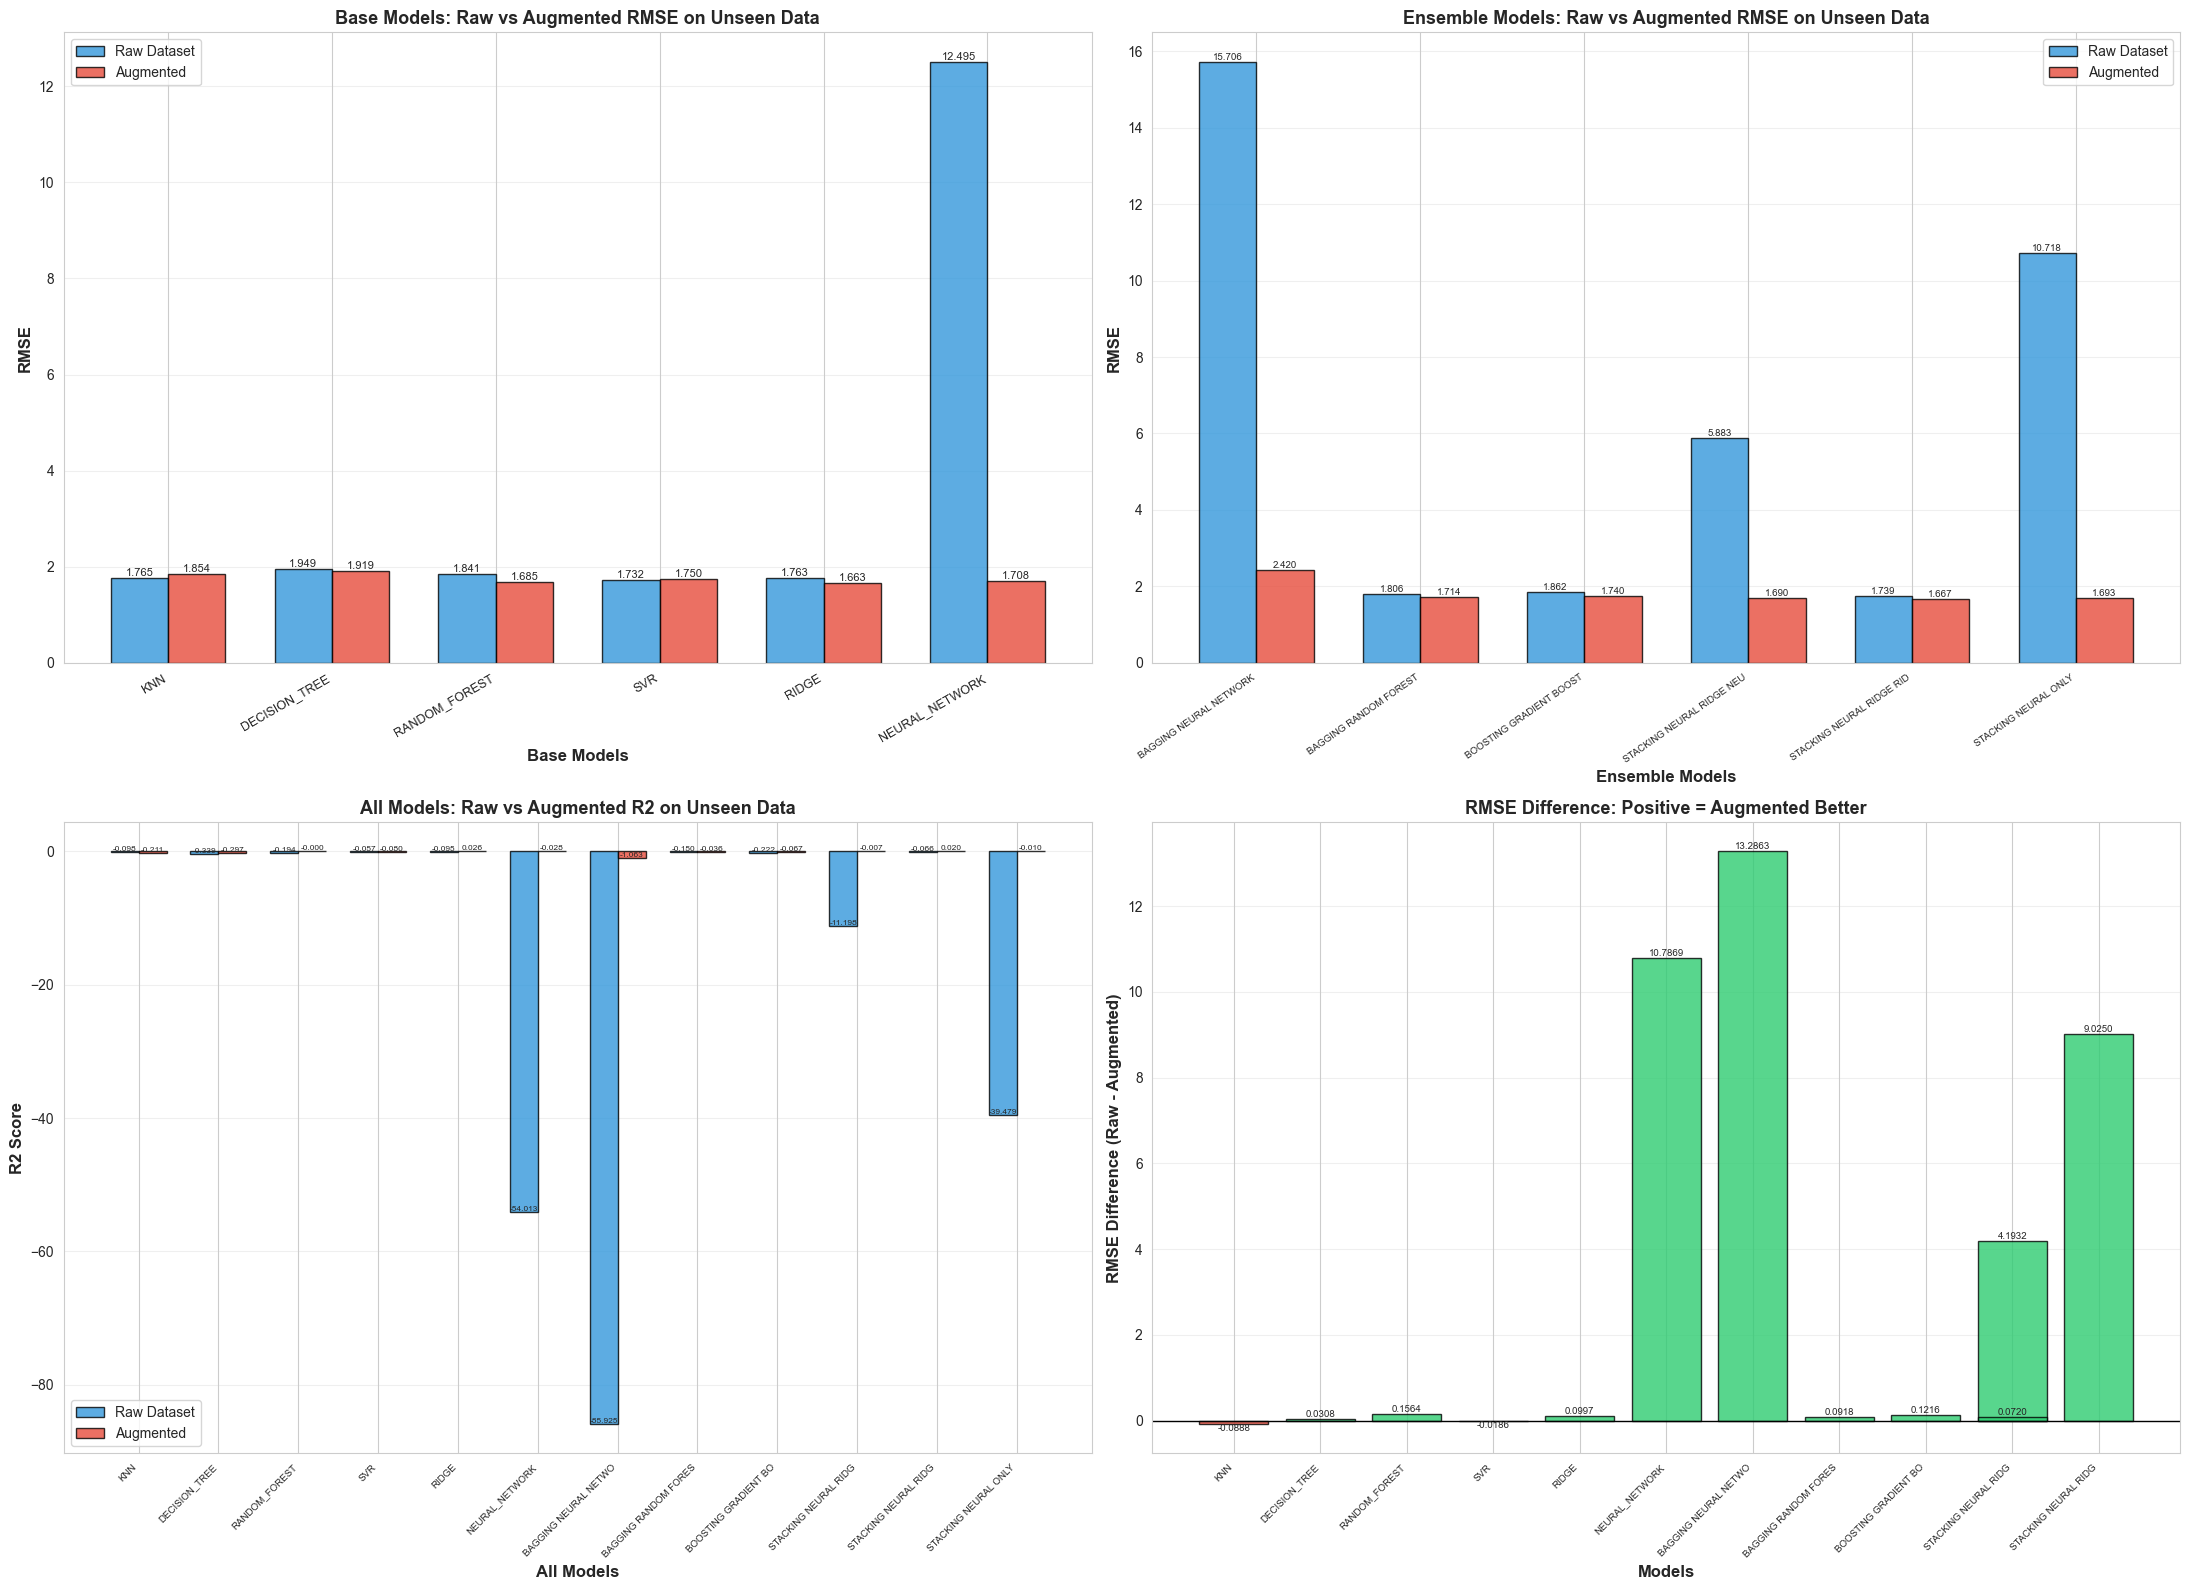

PER-SAMPLE PREDICTION DETAILS

Best Raw Dataset Model: SVR
Best Augmented Model: RIDGE

Per-Sample Predictions (Best Models):
 Sample  Actual  Pred_Raw_SVR  Pred_Aug_RIDGE  Error_Raw  Error_Aug    Better
      1 77.7000       76.7800         74.9302     0.9200     2.7698       Raw
      2 79.4000       76.8262         76.6195     2.5738     2.7805       Raw
      3 74.8000       76.8336         76.5393     2.0336     1.7393 Augmented
      4 74.8000       76.8037         76.9511     2.0037     2.1511       Raw
      5 74.6000       76.8691         76.1884     2.2691     1.5884 Augmented
      6 74.9000       76.7707         76.4994     1.8707     1.5994 Augmented
      7 76.6000       76.7897         77.2743     0.1897     0.6743       Raw
      8 75.8000       76.8104         77.6059     1.0104     1.8059       Raw
      9 78.8000       76.8259         76.8380     1.9741     1.9620 Augmented
     10 78.8000       76.8760         76.9204     1.9240     1.8796 Augmented
     11 75.2000 

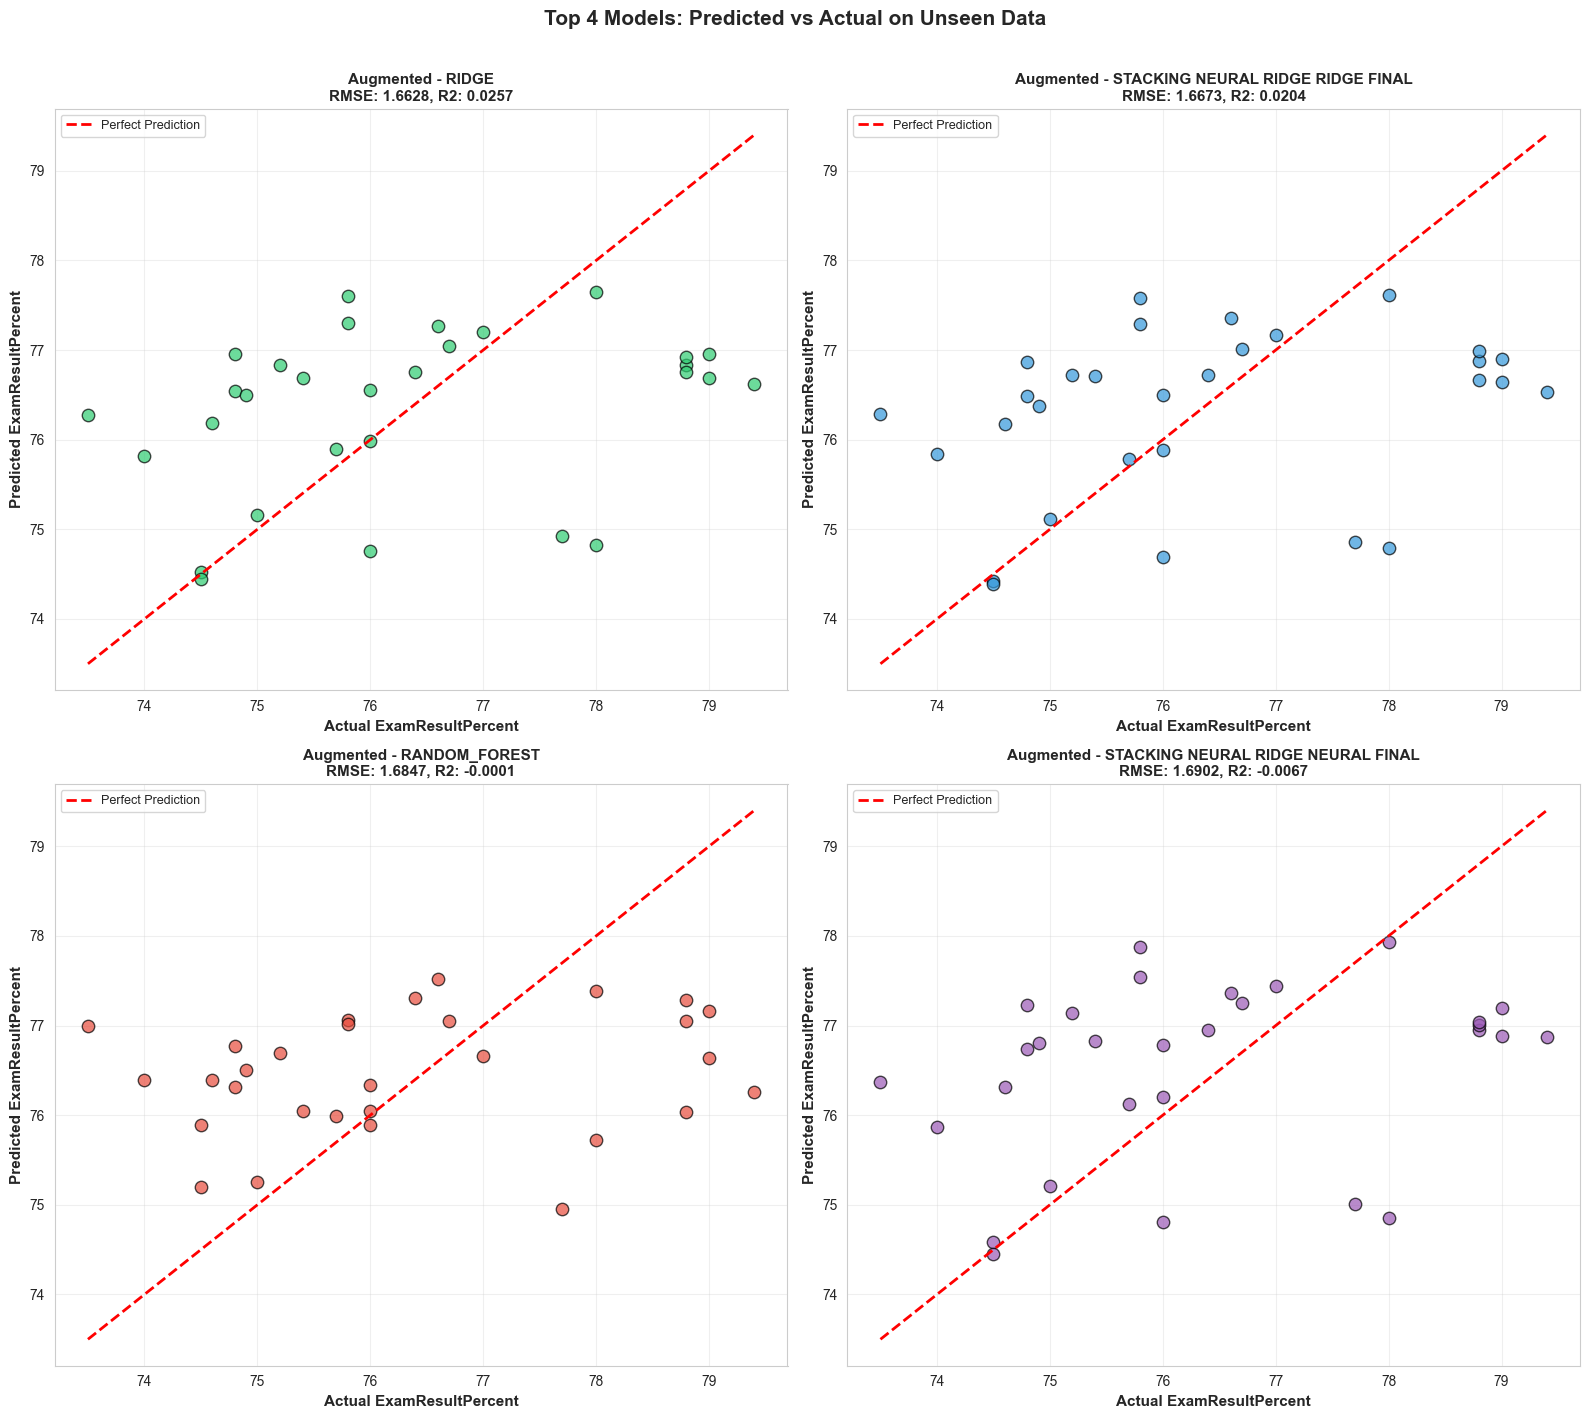

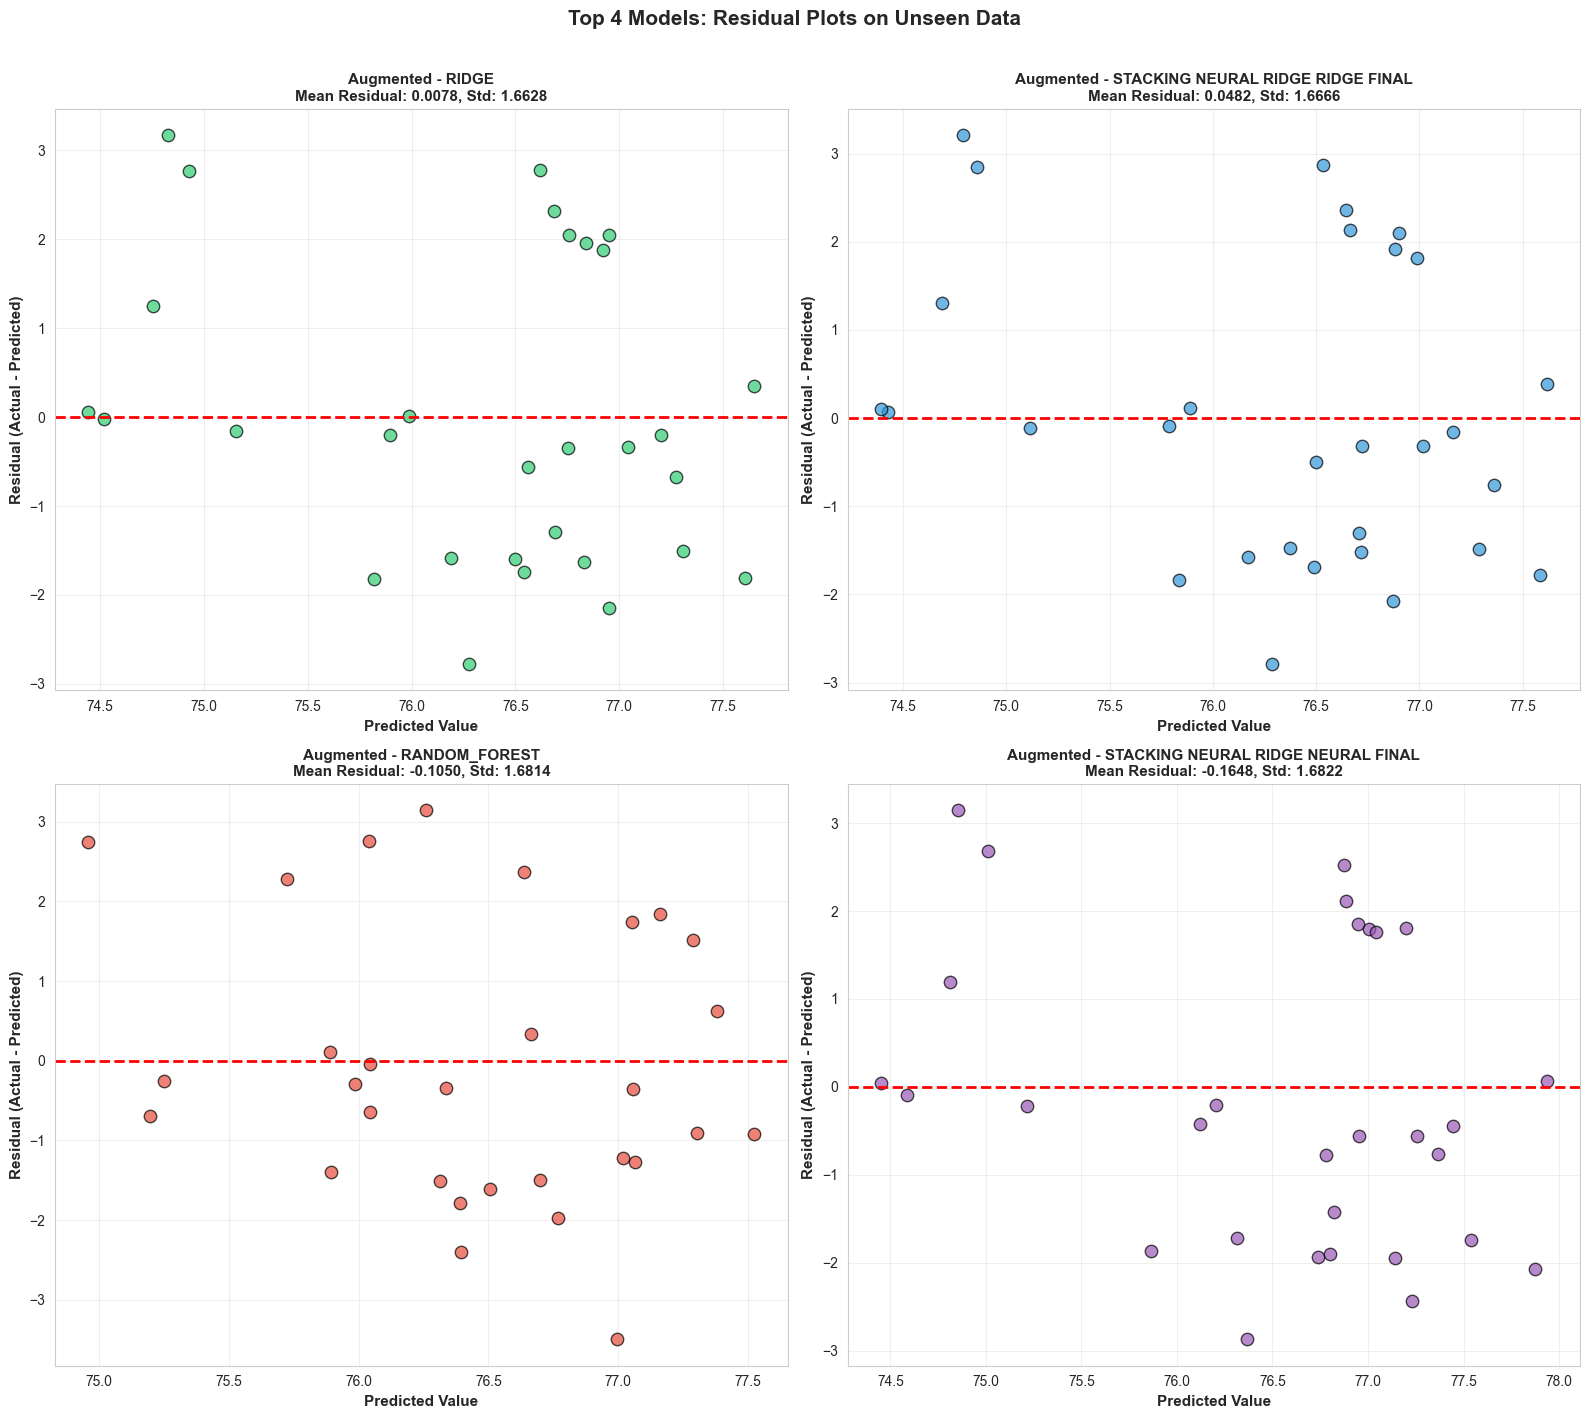

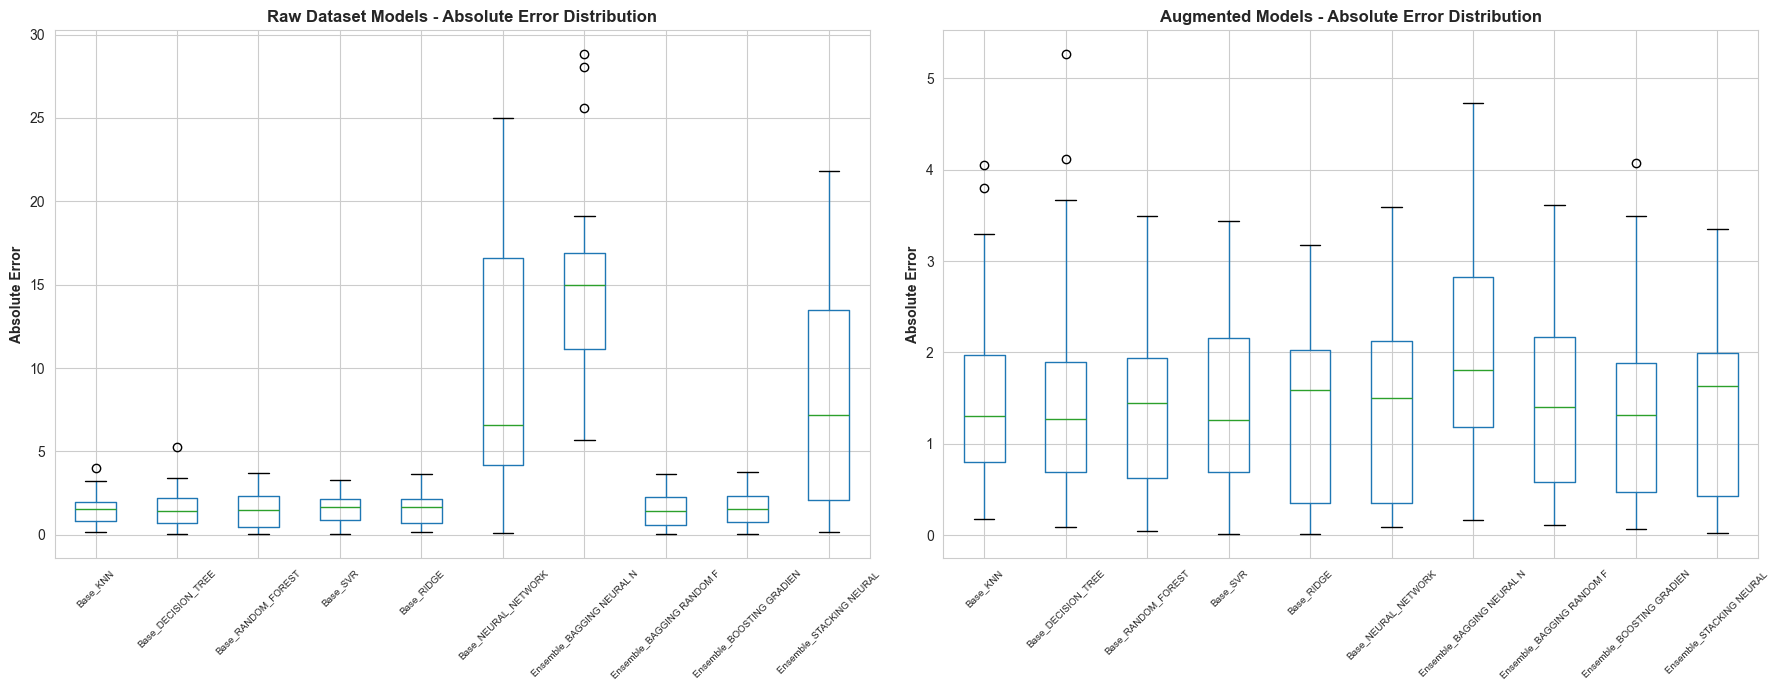

Saved: models/unseen_data_results/unseen_data_all_results.csv
Saved: models/unseen_data_results/raw_vs_augmented_comparison.csv
Saved: models/unseen_data_results/unseen_data_all_predictions.csv

UNSEEN DATA TESTING COMPLETE
Total models tested: 24
   Raw Dataset models: 12
   Augmented models: 12
Unseen data samples: 30
Results saved to: models/unseen_data_results/


In [2]:
# Cell 1: Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import pickle
import os
import json
import sys
import warnings
warnings.filterwarnings('ignore')

# Add parent directory so we can import preprocessor class
models_path = os.path.abspath('..')
if models_path not in sys.path:
    sys.path.insert(0, models_path)

from sklearn.experimental import enable_iterative_imputer
from regression_preprocessor import RegressionPreprocessor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (16, 8)

print("All libraries imported successfully")

# Cell 2: Load Unseen Data
unseen_df = pd.read_csv('../data/unseen_data.csv')

print("UNSEEN DATA OVERVIEW")
print("=" * 60)
print(f"Shape: {unseen_df.shape}")
print(f"Columns: {list(unseen_df.columns)}")
print(f"\nFirst 5 rows:")
print(unseen_df.head().to_string())

print(f"\nMissing values:")
print(unseen_df.isnull().sum()[unseen_df.isnull().sum() > 0])

print(f"\nTarget column (ExamResultPercent) stats:")
print(f"   Mean: {unseen_df['ExamResultPercent'].mean():.2f}")
print(f"   Std: {unseen_df['ExamResultPercent'].std():.2f}")
print(f"   Min: {unseen_df['ExamResultPercent'].min():.2f}")
print(f"   Max: {unseen_df['ExamResultPercent'].max():.2f}")

# Separate features and target
y_unseen = unseen_df['ExamResultPercent'].values
# Keep the full dataframe for preprocessing (preprocessor will handle column selection)
print(f"\nTarget (y_unseen) shape: {y_unseen.shape}")

# Cell 3: Load Preprocessors
# Dataset preprocessor (trained on raw data)
dataset_preprocessor = joblib.load('../regression_processed_data_dataset/preprocessor.pkl')
print(f"Dataset Preprocessor loaded: {dataset_preprocessor}")
print(f"   Feature count: {len(dataset_preprocessor.get_feature_names())}")

# Augmented preprocessor (trained on augmented data)
augmented_preprocessor = joblib.load('../regression_processed_data/preprocessor.pkl')
print(f"Augmented Preprocessor loaded: {augmented_preprocessor}")
print(f"   Feature count: {len(augmented_preprocessor.get_feature_names())}")

# Cell 4: Preprocess Unseen Data with Both Preprocessors
# Preprocess for dataset models (raw data trained)
print("PREPROCESSING UNSEEN DATA")
print("=" * 60)

try:
    X_unseen_dataset = dataset_preprocessor.transform(unseen_df)
    print(f"Dataset preprocessor output shape: {X_unseen_dataset.shape}")
except Exception as e:
    print(f"Error with dataset preprocessor: {e}")
    # Fallback: try manual preprocessing
    import traceback
    traceback.print_exc()

try:
    X_unseen_augmented = augmented_preprocessor.transform(unseen_df)
    print(f"Augmented preprocessor output shape: {X_unseen_augmented.shape}")
except Exception as e:
    print(f"Error with augmented preprocessor: {e}")
    import traceback
    traceback.print_exc()

print("\nPreprocessing complete for both model sets")

# Cell 5: Load All Dataset Models (Trained on Raw Data)
print("=" * 70)
print("LOADING DATASET MODELS (TRAINED ON RAW DATA)")
print("=" * 70)

# Base models trained on raw dataset
dataset_base_models = {}
base_model_names = ['knn', 'decision_tree', 'random_forest', 'svr', 'ridge', 'neural_network']

for name in base_model_names:
    model_path = f'../saved_base_models_dataset/{name}_model.pkl'
    try:
        dataset_base_models[name] = joblib.load(model_path)
        print(f"   [OK] Loaded: {name}_model.pkl")
    except Exception as e:
        print(f"   [ERROR] Failed to load {name}_model.pkl: {e}")

# Ensemble models trained on raw dataset
dataset_ensemble_models = {}
ensemble_model_names = [
    'bagging_neural_network',
    'bagging_random_forest',
    'boosting_gradient_boost',
    'stacking_neural_ridge_neural_final',
    'stacking_neural_ridge_ridge_final',
    'stacking_neural_only'
]

for name in ensemble_model_names:
    model_path = f'../saved_ensemble_models_dataset/{name}_ensemble.pkl'
    try:
        with open(model_path, 'rb') as f:
            dataset_ensemble_models[name] = pickle.load(f)
        print(f"   [OK] Loaded: {name}_ensemble.pkl")
    except Exception as e:
        print(f"   [ERROR] Failed to load {name}_ensemble.pkl: {e}")

print(f"\nDataset base models loaded: {len(dataset_base_models)}")
print(f"Dataset ensemble models loaded: {len(dataset_ensemble_models)}")

# Cell 6: Load All Augmented Models (Trained on Augmented Data)
print("=" * 70)
print("LOADING AUGMENTED MODELS (TRAINED ON AUGMENTED DATA)")
print("=" * 70)

# Base models trained on augmented data
augmented_base_models = {}
for name in base_model_names:
    model_path = f'../saved_base_models/{name}_model.pkl'
    try:
        augmented_base_models[name] = joblib.load(model_path)
        print(f"   [OK] Loaded: {name}_model.pkl")
    except Exception as e:
        print(f"   [ERROR] Failed to load {name}_model.pkl: {e}")

# Ensemble models trained on augmented data
augmented_ensemble_models = {}
for name in ensemble_model_names:
    model_path = f'../saved_ensemble_models/{name}_ensemble.pkl'
    try:
        with open(model_path, 'rb') as f:
            augmented_ensemble_models[name] = pickle.load(f)
        print(f"   [OK] Loaded: {name}_ensemble.pkl")
    except Exception as e:
        print(f"   [ERROR] Failed to load {name}_ensemble.pkl: {e}")

print(f"\nAugmented base models loaded: {len(augmented_base_models)}")
print(f"Augmented ensemble models loaded: {len(augmented_ensemble_models)}")

# Cell 7: Predict with Dataset Models (Raw Data Trained) on Unseen Data
print("=" * 70)
print("PREDICTIONS: DATASET MODELS (TRAINED ON RAW DATA)")
print("=" * 70)

dataset_predictions = {}

# Base model predictions
print("\n--- BASE MODELS ---")
for name, model in dataset_base_models.items():
    try:
        y_pred = model.predict(X_unseen_dataset)
        
        mse = mean_squared_error(y_unseen, y_pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_unseen, y_pred)
        r2 = r2_score(y_unseen, y_pred)
        
        dataset_predictions[f"BASE_{name}"] = {
            'type': 'Base',
            'model_name': name.upper(),
            'training_data': 'Raw Dataset',
            'y_pred': y_pred,
            'rmse': rmse,
            'mae': mae,
            'r2': r2,
            'mse': mse
        }
        
        print(f"\n   {name.upper()}:")
        print(f"      RMSE: {rmse:.4f}")
        print(f"      MAE:  {mae:.4f}")
        print(f"      R2:   {r2:.4f}")
    except Exception as e:
        print(f"   [ERROR] {name.upper()}: {e}")

# Ensemble model predictions
print("\n--- ENSEMBLE MODELS ---")
for name, model in dataset_ensemble_models.items():
    try:
        y_pred = model.predict(X_unseen_dataset)
        
        mse = mean_squared_error(y_unseen, y_pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_unseen, y_pred)
        r2 = r2_score(y_unseen, y_pred)
        
        dataset_predictions[f"ENSEMBLE_{name}"] = {
            'type': 'Ensemble',
            'model_name': name.replace('_', ' ').upper(),
            'training_data': 'Raw Dataset',
            'y_pred': y_pred,
            'rmse': rmse,
            'mae': mae,
            'r2': r2,
            'mse': mse
        }
        
        print(f"\n   {name.replace('_', ' ').upper()}:")
        print(f"      RMSE: {rmse:.4f}")
        print(f"      MAE:  {mae:.4f}")
        print(f"      R2:   {r2:.4f}")
    except Exception as e:
        print(f"   [ERROR] {name.upper()}: {e}")


# Cell 8: Predict with Augmented Models (Augmented Data Trained) on Unseen Data
print("=" * 70)
print("PREDICTIONS: AUGMENTED MODELS (TRAINED ON AUGMENTED DATA)")
print("=" * 70)

augmented_predictions = {}

# Base model predictions
print("\n--- BASE MODELS ---")
for name, model in augmented_base_models.items():
    try:
        y_pred = model.predict(X_unseen_augmented)
        
        mse = mean_squared_error(y_unseen, y_pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_unseen, y_pred)
        r2 = r2_score(y_unseen, y_pred)
        
        augmented_predictions[f"BASE_{name}"] = {
            'type': 'Base',
            'model_name': name.upper(),
            'training_data': 'Augmented',
            'y_pred': y_pred,
            'rmse': rmse,
            'mae': mae,
            'r2': r2,
            'mse': mse
        }
        
        print(f"\n   {name.upper()}:")
        print(f"      RMSE: {rmse:.4f}")
        print(f"      MAE:  {mae:.4f}")
        print(f"      R2:   {r2:.4f}")
    except Exception as e:
        print(f"   [ERROR] {name.upper()}: {e}")

# Ensemble model predictions
print("\n--- ENSEMBLE MODELS ---")
for name, model in augmented_ensemble_models.items():
    try:
        y_pred = model.predict(X_unseen_augmented)
        
        mse = mean_squared_error(y_unseen, y_pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_unseen, y_pred)
        r2 = r2_score(y_unseen, y_pred)
        
        augmented_predictions[f"ENSEMBLE_{name}"] = {
            'type': 'Ensemble',
            'model_name': name.replace('_', ' ').upper(),
            'training_data': 'Augmented',
            'y_pred': y_pred,
            'rmse': rmse,
            'mae': mae,
            'r2': r2,
            'mse': mse
        }
        
        print(f"\n   {name.replace('_', ' ').upper()}:")
        print(f"      RMSE: {rmse:.4f}")
        print(f"      MAE:  {mae:.4f}")
        print(f"      R2:   {r2:.4f}")
    except Exception as e:
        print(f"   [ERROR] {name.upper()}: {e}")

# Cell 9: Combined Summary Table - All Models
print("=" * 110)
print("COMPLETE UNSEEN DATA PERFORMANCE SUMMARY")
print("=" * 110)

all_results = []

# Add dataset model results
for key, data in dataset_predictions.items():
    all_results.append({
        'Training Data': data['training_data'],
        'Type': data['type'],
        'Model': data['model_name'],
        'RMSE': data['rmse'],
        'MAE': data['mae'],
        'R2': data['r2'],
        'MSE': data['mse']
    })

# Add augmented model results
for key, data in augmented_predictions.items():
    all_results.append({
        'Training Data': data['training_data'],
        'Type': data['type'],
        'Model': data['model_name'],
        'RMSE': data['rmse'],
        'MAE': data['mae'],
        'R2': data['r2'],
        'MSE': data['mse']
    })

results_df = pd.DataFrame(all_results)
results_df = results_df.sort_values('RMSE')

# Format for display
display_df = results_df.copy()
display_df['RMSE'] = display_df['RMSE'].apply(lambda x: f"{x:.4f}")
display_df['MAE'] = display_df['MAE'].apply(lambda x: f"{x:.4f}")
display_df['R2'] = display_df['R2'].apply(lambda x: f"{x:.4f}")
display_df['MSE'] = display_df['MSE'].apply(lambda x: f"{x:.4f}")

print("\nALL MODELS RANKED BY RMSE (BEST TO WORST):")
print(display_df.to_string(index=False))

# Best overall
best = results_df.iloc[0]
print(f"\nBest Overall Model on Unseen Data:")
print(f"   Model: {best['Model']}")
print(f"   Training Data: {best['Training Data']}")
print(f"   Type: {best['Type']}")
print(f"   RMSE: {best['RMSE']:.4f}")
print(f"   MAE: {best['MAE']:.4f}")
print(f"   R2: {best['R2']:.4f}")

# Cell 10: Side-by-Side Comparison - Raw vs Augmented for Each Model
print("=" * 110)
print("SIDE-BY-SIDE COMPARISON: RAW DATASET vs AUGMENTED TRAINING DATA")
print("=" * 110)

comparison_rows = []

# Compare base models
for name in base_model_names:
    dataset_key = f"BASE_{name}"
    augmented_key = f"BASE_{name}"
    
    if dataset_key in dataset_predictions and augmented_key in augmented_predictions:
        d = dataset_predictions[dataset_key]
        a = augmented_predictions[augmented_key]
        
        rmse_diff = d['rmse'] - a['rmse']
        mae_diff = d['mae'] - a['mae']
        r2_diff = a['r2'] - d['r2']
        
        comparison_rows.append({
            'Type': 'Base',
            'Model': name.upper(),
            'Raw RMSE': d['rmse'],
            'Aug RMSE': a['rmse'],
            'RMSE Diff': rmse_diff,
            'Raw MAE': d['mae'],
            'Aug MAE': a['mae'],
            'MAE Diff': mae_diff,
            'Raw R2': d['r2'],
            'Aug R2': a['r2'],
            'R2 Diff': r2_diff,
            'Better': 'Augmented' if a['rmse'] < d['rmse'] else 'Raw Dataset'
        })

# Compare ensemble models
for name in ensemble_model_names:
    dataset_key = f"ENSEMBLE_{name}"
    augmented_key = f"ENSEMBLE_{name}"
    
    if dataset_key in dataset_predictions and augmented_key in augmented_predictions:
        d = dataset_predictions[dataset_key]
        a = augmented_predictions[augmented_key]
        
        rmse_diff = d['rmse'] - a['rmse']
        mae_diff = d['mae'] - a['mae']
        r2_diff = a['r2'] - d['r2']
        
        comparison_rows.append({
            'Type': 'Ensemble',
            'Model': name.replace('_', ' ').upper(),
            'Raw RMSE': d['rmse'],
            'Aug RMSE': a['rmse'],
            'RMSE Diff': rmse_diff,
            'Raw MAE': d['mae'],
            'Aug MAE': a['mae'],
            'MAE Diff': mae_diff,
            'Raw R2': d['r2'],
            'Aug R2': a['r2'],
            'R2 Diff': r2_diff,
            'Better': 'Augmented' if a['rmse'] < d['rmse'] else 'Raw Dataset'
        })

comparison_df = pd.DataFrame(comparison_rows)

# Display formatted
print("\n" + comparison_df.to_string(index=False, float_format='{:.4f}'.format))

# Count which training approach wins
raw_wins = sum(1 for r in comparison_rows if r['Better'] == 'Raw Dataset')
aug_wins = sum(1 for r in comparison_rows if r['Better'] == 'Augmented')
print(f"\nRaw Dataset wins: {raw_wins} models")
print(f"Augmented wins: {aug_wins} models")

# NOTE: Positive RMSE Diff means Raw is worse (higher RMSE), Augmented is better
# NOTE: Positive R2 Diff means Augmented is better (higher R2)
print("\nNote: RMSE Diff = Raw - Augmented (positive means Augmented is better)")
print("Note: R2 Diff = Augmented - Raw (positive means Augmented is better)")

# Cell 11: Visualization - RMSE Comparison Bar Chart
fig, axes = plt.subplots(2, 2, figsize=(22, 16))

# Plot 1: Base Models - Raw vs Augmented RMSE
base_comparison = [r for r in comparison_rows if r['Type'] == 'Base']
if base_comparison:
    base_names = [r['Model'] for r in base_comparison]
    raw_rmse = [r['Raw RMSE'] for r in base_comparison]
    aug_rmse = [r['Aug RMSE'] for r in base_comparison]
    
    x = np.arange(len(base_names))
    width = 0.35
    
    bars1 = axes[0, 0].bar(x - width/2, raw_rmse, width, label='Raw Dataset', 
                           color='#3498db', alpha=0.8, edgecolor='black')
    bars2 = axes[0, 0].bar(x + width/2, aug_rmse, width, label='Augmented', 
                           color='#e74c3c', alpha=0.8, edgecolor='black')
    
    for bar in bars1:
        height = bar.get_height()
        axes[0, 0].text(bar.get_x() + bar.get_width()/2., height,
                       f'{height:.3f}', ha='center', va='bottom', fontsize=8)
    for bar in bars2:
        height = bar.get_height()
        axes[0, 0].text(bar.get_x() + bar.get_width()/2., height,
                       f'{height:.3f}', ha='center', va='bottom', fontsize=8)
    
    axes[0, 0].set_xlabel('Base Models', fontweight='bold', fontsize=12)
    axes[0, 0].set_ylabel('RMSE', fontweight='bold', fontsize=12)
    axes[0, 0].set_title('Base Models: Raw vs Augmented RMSE on Unseen Data', fontweight='bold', fontsize=13)
    axes[0, 0].set_xticks(x)
    axes[0, 0].set_xticklabels(base_names, rotation=30, ha='right', fontsize=9)
    axes[0, 0].legend(fontsize=10)
    axes[0, 0].grid(axis='y', alpha=0.3)

# Plot 2: Ensemble Models - Raw vs Augmented RMSE
ensemble_comparison = [r for r in comparison_rows if r['Type'] == 'Ensemble']
if ensemble_comparison:
    ens_names = [r['Model'][:25] for r in ensemble_comparison]
    raw_rmse_ens = [r['Raw RMSE'] for r in ensemble_comparison]
    aug_rmse_ens = [r['Aug RMSE'] for r in ensemble_comparison]
    
    x_ens = np.arange(len(ens_names))
    
    bars1 = axes[0, 1].bar(x_ens - width/2, raw_rmse_ens, width, label='Raw Dataset', 
                           color='#3498db', alpha=0.8, edgecolor='black')
    bars2 = axes[0, 1].bar(x_ens + width/2, aug_rmse_ens, width, label='Augmented', 
                           color='#e74c3c', alpha=0.8, edgecolor='black')
    
    for bar in bars1:
        height = bar.get_height()
        axes[0, 1].text(bar.get_x() + bar.get_width()/2., height,
                       f'{height:.3f}', ha='center', va='bottom', fontsize=7)
    for bar in bars2:
        height = bar.get_height()
        axes[0, 1].text(bar.get_x() + bar.get_width()/2., height,
                       f'{height:.3f}', ha='center', va='bottom', fontsize=7)
    
    axes[0, 1].set_xlabel('Ensemble Models', fontweight='bold', fontsize=12)
    axes[0, 1].set_ylabel('RMSE', fontweight='bold', fontsize=12)
    axes[0, 1].set_title('Ensemble Models: Raw vs Augmented RMSE on Unseen Data', fontweight='bold', fontsize=13)
    axes[0, 1].set_xticks(x_ens)
    axes[0, 1].set_xticklabels(ens_names, rotation=35, ha='right', fontsize=7)
    axes[0, 1].legend(fontsize=10)
    axes[0, 1].grid(axis='y', alpha=0.3)

# Plot 3: R2 Comparison - All Models
all_model_names = [r['Model'][:20] for r in comparison_rows]
raw_r2_all = [r['Raw R2'] for r in comparison_rows]
aug_r2_all = [r['Aug R2'] for r in comparison_rows]

x_all = np.arange(len(all_model_names))
width_all = 0.35

bars1 = axes[1, 0].bar(x_all - width_all/2, raw_r2_all, width_all, label='Raw Dataset', 
                       color='#3498db', alpha=0.8, edgecolor='black')
bars2 = axes[1, 0].bar(x_all + width_all/2, aug_r2_all, width_all, label='Augmented', 
                       color='#e74c3c', alpha=0.8, edgecolor='black')

for bar in bars1:
    height = bar.get_height()
    axes[1, 0].text(bar.get_x() + bar.get_width()/2., height,
                   f'{height:.3f}', ha='center', va='bottom', fontsize=6)
for bar in bars2:
    height = bar.get_height()
    axes[1, 0].text(bar.get_x() + bar.get_width()/2., height,
                   f'{height:.3f}', ha='center', va='bottom', fontsize=6)

axes[1, 0].set_xlabel('All Models', fontweight='bold', fontsize=12)
axes[1, 0].set_ylabel('R2 Score', fontweight='bold', fontsize=12)
axes[1, 0].set_title('All Models: Raw vs Augmented R2 on Unseen Data', fontweight='bold', fontsize=13)
axes[1, 0].set_xticks(x_all)
axes[1, 0].set_xticklabels(all_model_names, rotation=45, ha='right', fontsize=7)
axes[1, 0].legend(fontsize=10)
axes[1, 0].grid(axis='y', alpha=0.3)

# Plot 4: RMSE Difference (Raw - Augmented)
rmse_diffs = [r['RMSE Diff'] for r in comparison_rows]
bar_colors = ['#2ecc71' if d > 0 else '#e74c3c' for d in rmse_diffs]

bars = axes[1, 1].bar(all_model_names, rmse_diffs, color=bar_colors, alpha=0.8, edgecolor='black')

for bar in bars:
    height = bar.get_height()
    va = 'bottom' if height >= 0 else 'top'
    axes[1, 1].text(bar.get_x() + bar.get_width()/2., height,
                   f'{height:.4f}', ha='center', va=va, fontsize=7)

axes[1, 1].axhline(y=0, color='black', linewidth=1)
axes[1, 1].set_xlabel('Models', fontweight='bold', fontsize=12)
axes[1, 1].set_ylabel('RMSE Difference (Raw - Augmented)', fontweight='bold', fontsize=12)
axes[1, 1].set_title('RMSE Difference: Positive = Augmented Better', fontweight='bold', fontsize=13)
axes[1, 1].set_xticklabels(all_model_names, rotation=45, ha='right', fontsize=7)
axes[1, 1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Cell 12: Detailed Per-Sample Predictions for Best Models
print("=" * 70)
print("PER-SAMPLE PREDICTION DETAILS")
print("=" * 70)

# Find best model from each training approach
best_dataset_key = min(dataset_predictions.items(), key=lambda x: x[1]['rmse'])
best_augmented_key = min(augmented_predictions.items(), key=lambda x: x[1]['rmse'])

print(f"\nBest Raw Dataset Model: {best_dataset_key[1]['model_name']}")
print(f"Best Augmented Model: {best_augmented_key[1]['model_name']}")

# Build per-sample comparison dataframe
per_sample_df = pd.DataFrame({
    'Sample': range(1, len(y_unseen) + 1),
    'Actual': y_unseen,
    f'Pred_Raw_{best_dataset_key[1]["model_name"]}': best_dataset_key[1]['y_pred'],
    f'Pred_Aug_{best_augmented_key[1]["model_name"]}': best_augmented_key[1]['y_pred'],
    f'Error_Raw': np.abs(y_unseen - best_dataset_key[1]['y_pred']),
    f'Error_Aug': np.abs(y_unseen - best_augmented_key[1]['y_pred']),
})

per_sample_df['Better'] = per_sample_df.apply(
    lambda row: 'Raw' if row['Error_Raw'] < row['Error_Aug'] else 'Augmented', axis=1
)

print(f"\nPer-Sample Predictions (Best Models):")
print(per_sample_df.to_string(index=False, float_format='{:.4f}'.format))

raw_better_count = (per_sample_df['Better'] == 'Raw').sum()
aug_better_count = (per_sample_df['Better'] == 'Augmented').sum()
print(f"\nRaw Dataset closer: {raw_better_count}/{len(y_unseen)} samples")
print(f"Augmented closer: {aug_better_count}/{len(y_unseen)} samples")

# Cell 13: Prediction vs Actual Scatter Plots (Top 4 Models)
# Get top 4 models overall by RMSE
all_predictions = {}
for k, v in dataset_predictions.items():
    all_predictions[f"Raw_{k}"] = v
for k, v in augmented_predictions.items():
    all_predictions[f"Aug_{k}"] = v

sorted_all = sorted(all_predictions.items(), key=lambda x: x[1]['rmse'])
top_4 = sorted_all[:4]

fig, axes = plt.subplots(2, 2, figsize=(16, 14))
axes_flat = axes.flatten()
colors_scatter = ['#2ecc71', '#3498db', '#e74c3c', '#9b59b6']

for idx, (key, data) in enumerate(top_4):
    ax = axes_flat[idx]
    y_pred = data['y_pred']
    
    ax.scatter(y_unseen, y_pred, alpha=0.7, s=80, color=colors_scatter[idx], edgecolor='black')
    
    min_val = min(y_unseen.min(), y_pred.min())
    max_val = max(y_unseen.max(), y_pred.max())
    ax.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Prediction')
    
    ax.set_xlabel('Actual ExamResultPercent', fontweight='bold', fontsize=11)
    ax.set_ylabel('Predicted ExamResultPercent', fontweight='bold', fontsize=11)
    ax.set_title(f"{data['training_data']} - {data['model_name']}\n"
                 f"RMSE: {data['rmse']:.4f}, R2: {data['r2']:.4f}", 
                 fontweight='bold', fontsize=11)
    ax.legend(fontsize=9)
    ax.grid(alpha=0.3)

plt.suptitle('Top 4 Models: Predicted vs Actual on Unseen Data', fontsize=15, fontweight='bold', y=1.01)
plt.tight_layout()
plt.show()

# Cell 14: Residual Analysis for Top Models
fig, axes = plt.subplots(2, 2, figsize=(16, 14))
axes_flat = axes.flatten()

for idx, (key, data) in enumerate(top_4):
    ax = axes_flat[idx]
    residuals = y_unseen - data['y_pred']
    
    ax.scatter(data['y_pred'], residuals, alpha=0.7, s=80, 
              color=colors_scatter[idx], edgecolor='black')
    ax.axhline(y=0, color='red', linewidth=2, linestyle='--')
    
    ax.set_xlabel('Predicted Value', fontweight='bold', fontsize=11)
    ax.set_ylabel('Residual (Actual - Predicted)', fontweight='bold', fontsize=11)
    ax.set_title(f"{data['training_data']} - {data['model_name']}\n"
                 f"Mean Residual: {np.mean(residuals):.4f}, Std: {np.std(residuals):.4f}",
                 fontweight='bold', fontsize=11)
    ax.grid(alpha=0.3)

plt.suptitle('Top 4 Models: Residual Plots on Unseen Data', fontsize=15, fontweight='bold', y=1.01)
plt.tight_layout()
plt.show()

# Cell 15: Error Distribution Comparison
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# All raw dataset model errors
raw_errors = {}
for key, data in dataset_predictions.items():
    model_label = f"{data['type']}_{data['model_name']}"[:25]
    raw_errors[model_label] = np.abs(y_unseen - data['y_pred'])

# All augmented model errors
aug_errors = {}
for key, data in augmented_predictions.items():
    model_label = f"{data['type']}_{data['model_name']}"[:25]
    aug_errors[model_label] = np.abs(y_unseen - data['y_pred'])

# Box plot for raw dataset models
raw_error_df = pd.DataFrame(raw_errors)
raw_error_df.boxplot(ax=axes[0], rot=45, grid=True)
axes[0].set_title('Raw Dataset Models - Absolute Error Distribution', fontweight='bold', fontsize=12)
axes[0].set_ylabel('Absolute Error', fontweight='bold')
axes[0].tick_params(axis='x', labelsize=7)

# Box plot for augmented models
aug_error_df = pd.DataFrame(aug_errors)
aug_error_df.boxplot(ax=axes[1], rot=45, grid=True)
axes[1].set_title('Augmented Models - Absolute Error Distribution', fontweight='bold', fontsize=12)
axes[1].set_ylabel('Absolute Error', fontweight='bold')
axes[1].tick_params(axis='x', labelsize=7)

plt.tight_layout()
plt.show()


# Cell 16: Save All Results to CSV
os.makedirs('../unseen_data_results', exist_ok=True)

# Save summary results
results_df.to_csv('../unseen_data_results/unseen_data_all_results.csv', index=False)
print("Saved: models/unseen_data_results/unseen_data_all_results.csv")

# Save comparison table
comparison_df.to_csv('../unseen_data_results/raw_vs_augmented_comparison.csv', index=False)
print("Saved: models/unseen_data_results/raw_vs_augmented_comparison.csv")

# Save per-sample predictions for all models
all_sample_predictions = pd.DataFrame({'Actual': y_unseen})

for key, data in dataset_predictions.items():
    col_name = f"Raw_{data['type']}_{data['model_name']}"
    all_sample_predictions[col_name] = data['y_pred']

for key, data in augmented_predictions.items():
    col_name = f"Aug_{data['type']}_{data['model_name']}"
    all_sample_predictions[col_name] = data['y_pred']

all_sample_predictions.to_csv('../unseen_data_results/unseen_data_all_predictions.csv', index=False)
print("Saved: models/unseen_data_results/unseen_data_all_predictions.csv")

print("\n" + "=" * 70)
print("UNSEEN DATA TESTING COMPLETE")
print("=" * 70)
print(f"Total models tested: {len(dataset_predictions) + len(augmented_predictions)}")
print(f"   Raw Dataset models: {len(dataset_predictions)}")
print(f"   Augmented models: {len(augmented_predictions)}")
print(f"Unseen data samples: {len(y_unseen)}")
print(f"Results saved to: models/unseen_data_results/")